# Intro

This notebook is used to train classifiers to predict used memory, and then save the trained model along with the data it used. This includes a decision tree, a random forest, a gradient boosted decision tree model, and a logistic regressor.

# Notebook options

The grid_search parameter determines whether the notebook will execute a grid search for each model to find the best combination of hyperparameters, or whether the notebook will just use some pre-set parameters (which were found in previous grid searches).

The save_model parameter determines whether to save a model at the end (currently it saves the random forest model).

The training_mode parameter can either be 'normal', 'test', or 'final'.

In [1]:
grid_search = True
save_model = True
training_mode = 'normal'

# Imports

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from hypopt import GridSearch
from datetime import datetime
from datetime import date
from preprocessing import get_df
from preprocessing import scale
from persistence import model_saver
from evaluation import score_model
from evaluation import print_feature_importances
from evaluation import plot_performance
from evaluation import plot_cm
from evaluation import print_cr
from evaluation import auc
import time

In [3]:
from sklearn.metrics import make_scorer

In [4]:
df = get_df()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50360 entries, 6132011 to 6785810
Data columns (total 38 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   request_type     50360 non-null  object             
 1   job_start_at     50360 non-null  datetime64[ns]     
 2   job_end_at       50360 non-null  datetime64[ns]     
 3   req_mem          50360 non-null  float64            
 4   used_mem         50360 non-null  float64            
 5   dsnum            48150 non-null  object             
 6   rqst_start_at    50327 non-null  datetime64[ns, UTC]
 7   rqst_end_at      50248 non-null  datetime64[ns, UTC]
 8   dates_init       50360 non-null  bool               
 9   slat             32123 non-null  float64            
 10  nlat             32123 non-null  float64            
 11  wlon             32140 non-null  float64            
 12  elon             32140 non-null  float64            
 13  gui     

In [6]:
df.sort_values(by='wall_time', ascending=False)['wall_time'].head(5)

6234832    177251.0
6236363     86408.0
6246421     85921.0
6236362     85916.0
6246463     85645.0
Name: wall_time, dtype: float64

In [7]:
time_bin_cutoffs = [60, 120, 300, 600, 1800, 3600, 14400, 43200]
num_classes = len(time_bin_cutoffs)
bin_sizes = [df[df.wall_time < time_bin_cutoffs[0]].shape[0]]
for i in range(1, len(time_bin_cutoffs)):
    current_bin_size = df[(df.wall_time >= time_bin_cutoffs[i-1])
                        & (df.wall_time < time_bin_cutoffs[i])].shape[0]
    bin_sizes.append(current_bin_size)

In [8]:
def print_time_categories():
    print(f"0: < {time_bin_cutoffs[0]}s ({bin_sizes[0]} entries)")
    for i in range(1, len(time_bin_cutoffs)):
        print(f"{i}: >= {time_bin_cutoffs[i-1]}s"
              + f" and < {time_bin_cutoffs[i]}s"
              + f" ({bin_sizes[i]} entries)")

In [9]:
print_time_categories()

0: < 60s (7371 entries)
1: >= 60s and < 120s (10720 entries)
2: >= 120s and < 300s (8174 entries)
3: >= 300s and < 600s (5519 entries)
4: >= 600s and < 1800s (7726 entries)
5: >= 1800s and < 3600s (4005 entries)
6: >= 3600s and < 14400s (5521 entries)
7: >= 14400s and < 43200s (1070 entries)


In [10]:
def time_category(row):
    time = min(row['wall_time'], 43199)
    if time < time_bin_cutoffs[0]:
        return 0
    for i in range(1, len(time_bin_cutoffs)):
        if time >= time_bin_cutoffs[i-1] and time < time_bin_cutoffs[i]:
            return i
    return None

In [11]:
df['time_category'] = df.apply(lambda row: time_category(row), axis=1)

In [12]:
df = df[df.rqst_timespan.notnull() & df.rqst_area_rect.notnull()]
X_features = ['PP', 'SP', 'BR', 'rqst_timespan', 'rqst_area_rect', 'converted',
              'params_num', 'grid_def_num', 'level_num',
              'ds084.1', 'ds631.1', 'ds083.3', 'ds094.0', 'ds083.2']
y_features = ['wall_time', 'time_category']

X = df[X_features]
y = df[y_features]

## Train/validation/test split

In [13]:
train_amt = 0.5
val_amt = 0.25
test_amt = 0.25

In [14]:
X_train, X_target, y_train_full, y_target_full = \
                train_test_split(X, y, 
                test_size=1-train_amt, 
                random_state = 3)
X_val, X_test, y_val_full, y_test_full = \
                train_test_split(X_target, y_target_full,
                                 test_size = test_amt/train_amt,
                                 random_state = 3)

In [15]:
y_train = np.ravel(y_train_full['time_category'])
y_val = np.ravel(y_val_full['time_category'])
y_test = np.ravel(y_test_full['time_category'])

## Scaling

In [16]:
X_train_norm, X_val_norm, X_test_norm = \
    scale(X_train, X_val, X_test)

In [17]:
def balanced_score(y, y_pred, **kwargs):
    n_samples = X_train.shape[0]
    class_weights = n_samples / (num_classes * (np.bincount(y_train)))
    print(class_weights)
    score = 0
    for i in range(len(y)):
        if y[i] == y_pred[i]:
            score += class_weights[y[i]]
        
    return score

balanced_scorer = make_scorer(score_func=balanced_score,
                              greater_is_better=True)

In [18]:
def custom_score(y, y_pred, **kwargs):
    n_samples = X_train.shape[0]
    class_weights = np.array([(i+1)**2 for i in range(num_classes)])
    #print(class_weights)
    score = 0
    for i in range(len(y)):
        if y[i] == y_pred[i]:
            score += class_weights[y[i]]
        
    return score

custom_scorer = make_scorer(score_func=custom_score,
                              greater_is_better=True)

In [19]:
custom_score(None, None)

TypeError: object of type 'NoneType' has no len()

In [20]:
class_weights = {i:float((i+1)**2) for i in range(num_classes)}
print(class_weights)

{0: 1.0, 1: 4.0, 2: 9.0, 3: 16.0, 4: 25.0, 5: 36.0, 6: 49.0, 7: 64.0}


## Trees, Forest, Gradient Boosts

### Tree

In [19]:
if grid_search:
    tree_param_grid = {'random_state':[3], 'max_depth':range(2,20),
                       'min_samples_split':range(2,8),
                       'class_weight':['balanced']}
    tree_gs = GridSearch(model=DecisionTreeClassifier(), 
                              param_grid=tree_param_grid,
                              parallelize=False)
    tree_gs.fit(X_train_norm, y_train, X_val_norm, y_val, scoring=balanced_scorer)
    print(tree_gs.best_params)
    tree = tree_gs.best_estimator_

else:
    tree = DecisionTreeClassifier(class_weight='balanced',
                                  max_depth=19, random_state=3)
    tree.fit(X_train_norm, y_train)

### Forest

In [24]:
if grid_search:
    start = time.time()
    forest_param_grid = {'random_state':[3],
                               'max_depth':range(2,20),
                               'min_samples_split':range(2,10),
                               'n_estimators':[50,100],
                               'class_weight':[class_weights]}
    forest_gs = GridSearch(model=RandomForestClassifier(), 
                                param_grid=forest_param_grid,
                                parallelize=False)
    forest_gs.fit(X_train_norm, y_train, X_val_norm, y_val,
                  scoring=custom_scorer)
    end = time.time()
    print(f"Time = {end-start}")
    print(forest_gs.best_params)
    forest = forest_gs.best_estimator_
else:
    forest = RandomForestClassifier(class_weight=class_weights,
                                      max_depth=19,
                                      min_samples_split=5,
                                      n_estimators=250,
                                      random_state=3)
    forest.fit(X_train_norm, y_train)

Time = 240.61198902130127
{'class_weight': {0: 1.0, 1: 4.0, 2: 9.0, 3: 16.0, 4: 25.0, 5: 36.0, 6: 49.0, 7: 64.0}, 'max_depth': 19, 'min_samples_split': 4, 'n_estimators': 100, 'random_state': 3}


In [21]:
if training_mode == 'test':
    new_X_train = np.concatenate((X_train_norm, X_val_norm))
    new_y_train = np.ravel(pd.concat([y_train_full,
                                      y_val_full])['mem_category'])
    forest.fit(new_X_train, new_y_train)
elif training_mode == 'final':
    new_X_train = np.concatenate((X_train_norm,
                                  X_val_norm,
                                  X_test_norm))
    new_y_train = np.ravel(pd.concat([y_train_full,
                                      y_val_full,
                                      y_test_full])['mem_category'])
    forest.fit(new_X_train, new_y_train)

### Gradient boosted trees

In [22]:
if grid_search:
    gboost_param_grid = {'random_state':[3],
                               'max_depth':range(2,15),
                               'n_estimators':[50,100,150,200]}
    gboost_gs = GridSearch(model=GradientBoostingClassifier(), 
                                param_grid=gboost_param_grid,
                                parallelize=False)
    gboost_gs.fit(X_train_norm, y_train, X_val_norm, y_val)
    print(class_gboost_gs.best_params)
    class_gboost = class_gboost_gs.best_estimator_
else:
    gboost = GradientBoostingClassifier(random_state=3,
                                        max_depth=14,
                                        n_estimators=150)
    #gboost.fit(X_train_norm, y_train)

In [23]:
if grid_search:
    hist_gboost_param_grid = {'random_state':[3],
                               'max_depth':range(2,20),
                               'min_samples_leaf':range(15,35,5),
                               'max_iter':[50,100,150]}
    hist_gboost_gs = GridSearch(model=HistGradientBoostingClassifier(), 
                                param_grid=hist_gboost_param_grid,
                                parallelize=False)
    hist_gboost_gs.fit(X_train_norm, y_train, X_val_norm, y_val)
    print(hist_gboost_gs.best_params)
    hist_gboost = hist_gboost_gs.best_estimator_
else:
    hist_gboost = HistGradientBoostingClassifier(random_state=3,
                                        max_depth=16,
                                        max_iter=150,
                                        min_samples_leaf=15)
    #gboost.fit(X_train_norm, y_train)

{'max_depth': 16, 'max_iter': 150, 'min_samples_leaf': 15, 'random_state': 3}


## Linear regressors

In [23]:
logist = LogisticRegression(max_iter=1000, class_weight='balanced')
logist.fit(X_train_norm, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [27]:
notes = "Time class forest, filling missing lat/lon with max value. " \
         + "Trained on train data only. " \
         + "Grid searched on Casper Batch job. " \
         + "X values NOT scaled. " \
         + "Uses custom class weights."

In [28]:
if save_model:
    ms = model_saver('time_forest', notes,
                   forest, df, 
                   X_features,
                   X_train, y_train_full,
                   X_val, y_val_full,
                   X_test, y_test_full)
    ms.save()

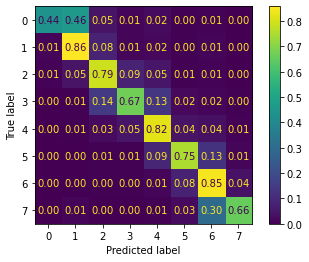

In [25]:
plot_cm(X_val=X_val_norm, y_val=y_val, model=forest)

In [26]:
print_cr(X_val_norm, y_val, forest)

              precision    recall  f1-score   support

           0       0.93      0.44      0.60      1846
           1       0.70      0.86      0.77      2659
           2       0.74      0.79      0.77      2059
           3       0.72      0.67      0.70      1385
           4       0.76      0.82      0.79      1920
           5       0.73      0.75      0.74       975
           6       0.76      0.85      0.80      1405
           7       0.66      0.66      0.66       305

    accuracy                           0.75     12554
   macro avg       0.75      0.73      0.73     12554
weighted avg       0.76      0.75      0.74     12554

